
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [ ]:
## library imports here

In [3]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score


In [4]:
X = ha.drop(columns=["cp"])
y = ha["cp"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [5]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

print("KNN Accuracy:", knn.score(X_test, y_test))


KNN Accuracy: 0.36585365853658536


In [6]:
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

print("Decision Tree Accuracy:", tree.score(X_test, y_test))


Decision Tree Accuracy: 0.5365853658536586


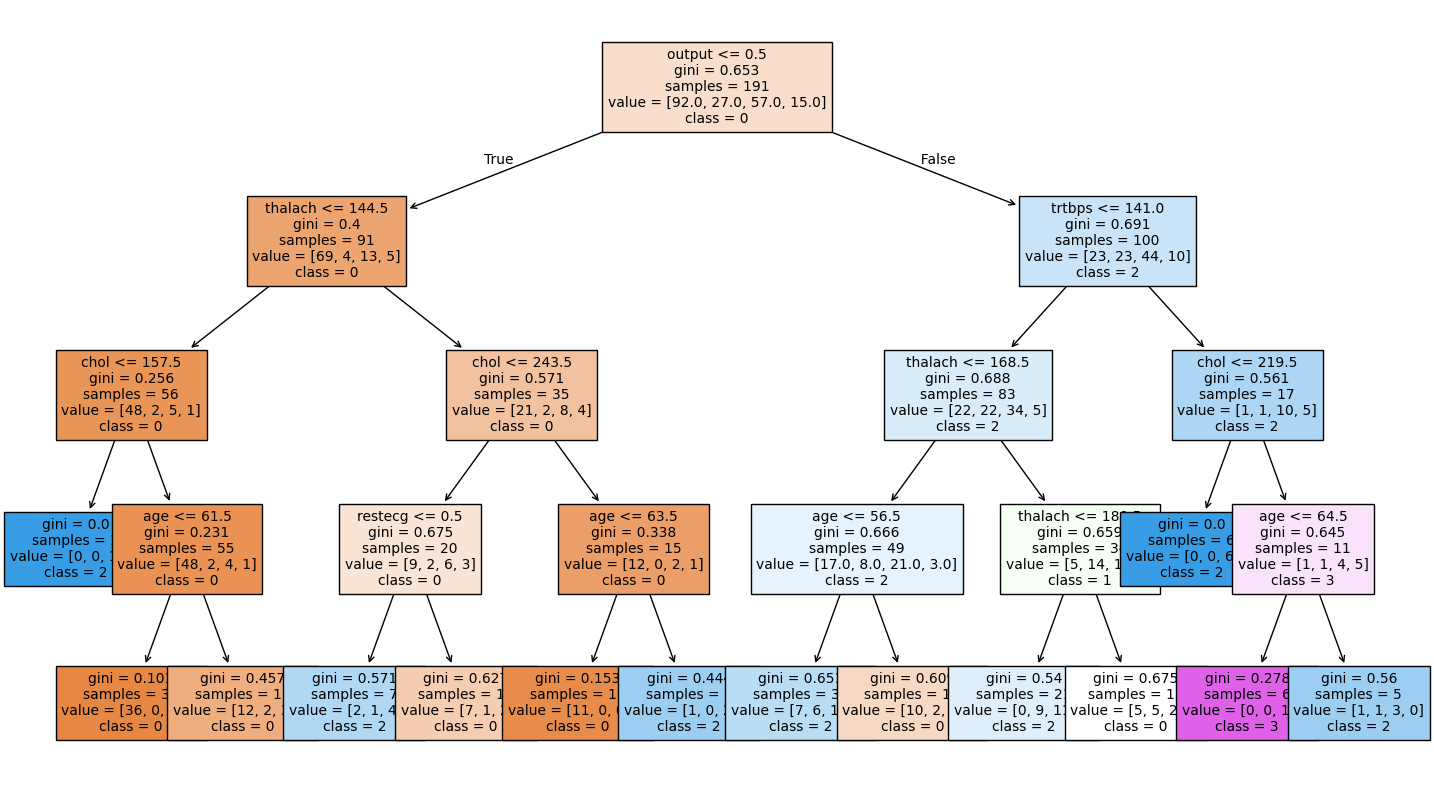

In [7]:
plt.figure(figsize=(18,10))
plot_tree(
    tree,
    feature_names=X.columns,
    class_names=["0","1","2","3"],
    filled=True,
    fontsize=10
)
plt.show()


In [8]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

print("LDA Accuracy:", lda.score(X_test, y_test))


LDA Accuracy: 0.5121951219512195


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [9]:
results_ovr = {}

for cp_type in [0,1,2,3]:

    # create new binary column
    ha[f"cp_is_{cp_type}"] = (ha["cp"] == cp_type).astype(int)

    y_binary = ha[f"cp_is_{cp_type}"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary, test_size=0.3, random_state=42
    )

    logit = LogisticRegression(max_iter=500)
    logit.fit(X_train, y_train)

    preds = logit.predict(X_test)
    f1 = f1_score(y_test, preds)

    results_ovr[f"cp_is_{cp_type}"] = f1

results_ovr


{'cp_is_0': 0.72,
 'cp_is_1': 0.0,
 'cp_is_2': 0.07142857142857142,
 'cp_is_3': 0.0}

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [10]:
pairs = [(0,1), (0,2), (0,3)]
results_ovo = {}

for a, b in pairs:

    # Filter to only two classes
    df_pair = ha[ha["cp"].isin([a, b])]

    X_pair = df_pair.drop(columns=["cp",
                                   "cp_is_0","cp_is_1","cp_is_2","cp_is_3"])

    # Label b = 1, a = 0
    y_pair = (df_pair["cp"] == b).astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X_pair, y_pair, test_size=0.3, random_state=42
    )

    logit = LogisticRegression(max_iter=500)
    logit.fit(X_train, y_train)

    prob = logit.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, prob)

    results_ovo[f"{a} vs {b}"] = auc

results_ovo


{'0 vs 1': np.float64(0.7916666666666667),
 '0 vs 2': np.float64(0.7849223946784922),
 '0 vs 3': np.float64(0.8257575757575757)}